In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

/home/proven/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Overview of the dataset

In [2]:
# Load your data
df = pd.read_csv("assignment_1/data/customer_service/train.csv")

# Basic info
df.info()
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 970 entries, 0 to 969
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   issue_area                   970 non-null    object
 1   issue_category               970 non-null    object
 2   issue_sub_category           970 non-null    object
 3   issue_category_sub_category  970 non-null    object
 4   customer_sentiment           970 non-null    object
 5   product_category             970 non-null    object
 6   product_sub_category         970 non-null    object
 7   issue_complexity             970 non-null    object
 8   agent_experience_level       970 non-null    object
 9   agent_experience_level_desc  970 non-null    object
 10  conversation                 970 non-null    object
dtypes: object(11)
memory usage: 83.5+ KB


,issue_area,issue_category,issue_sub_category,issue_category_sub_category,customer_sentiment,product_category,product_sub_category,issue_complexity,agent_experience_level,agent_experience_level_desc,conversation
count,970,970,970,970,970,970,970,970,970,970,970
unique,6,40,109,109,3,3,50,3,3,3,968
top,Cancellations and returns,Return and Exchange,Verification requirement for mobile number or ...,Mobile Number and Email Verification -> Verifi...,neutral,Appliances,Water Purifier,less,junior,"handles customer inquiries independently, poss...","Agent: You're welcome, Jane. Have a great day!"
freq,277,92,17,17,542,454,26,472,490,490,3


## Distribution of customer sentiment

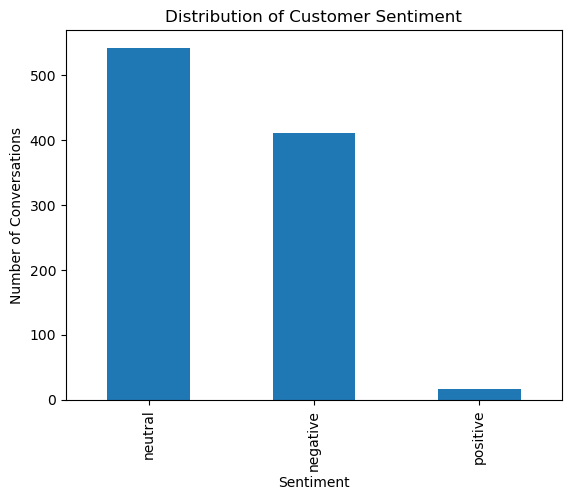

In [3]:
df['customer_sentiment'].value_counts().plot(kind='bar', title='Distribution of Customer Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Number of Conversations')
plt.show()

Neutral and negative conversations outnumber positive ones. There is a class imbalance issue.

## Issue Complexity by Sentiment

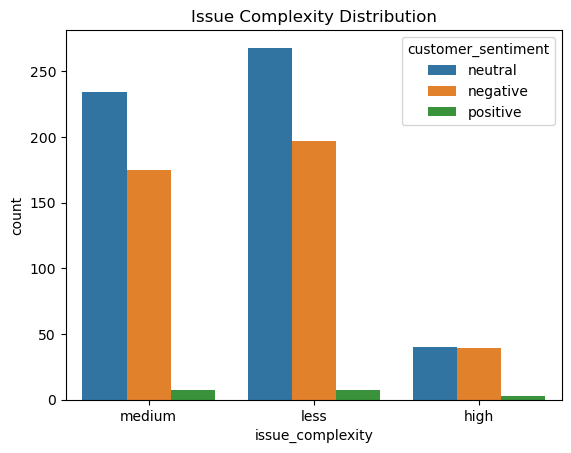

In [4]:
sns.countplot(data=df, x='issue_complexity', hue='customer_sentiment')
plt.title('Issue Complexity Distribution')
plt.show()

As issue complexity increases, the number of neutral conversations decreases.

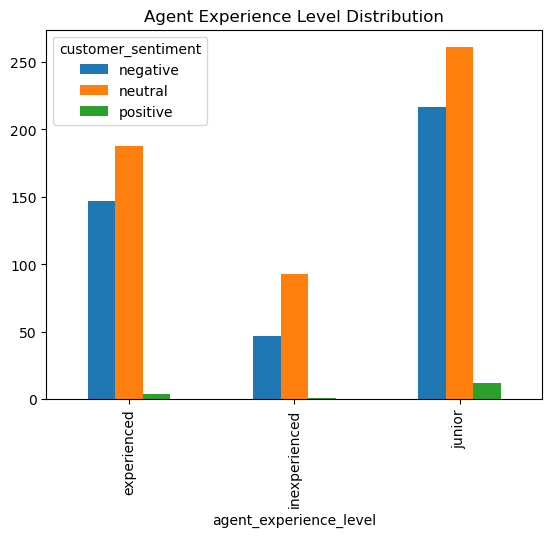

In [5]:
df.groupby(['agent_experience_level', 'customer_sentiment']).size().unstack().plot(kind='bar', stacked=False)
plt.title('Agent Experience Level Distribution')
plt.show()

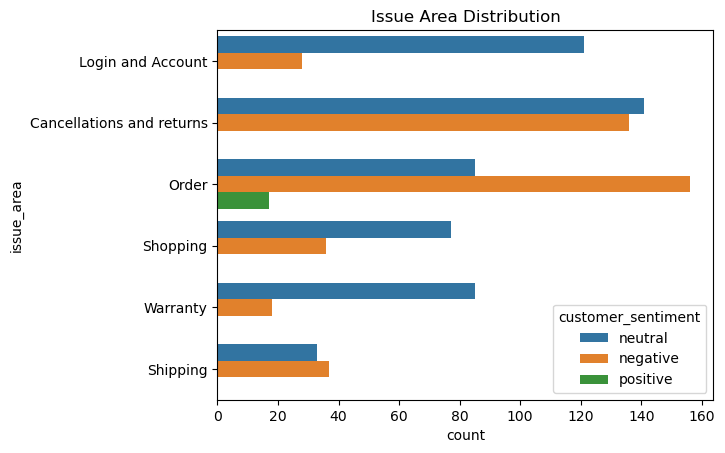

In [6]:
ax2 = sns.countplot(data=df, y='issue_area', hue='customer_sentiment')
plt.title('Issue Area Distribution')
plt.show()

## Conversation Length by Customer Sentiment

<Axes: xlabel='customer_sentiment', ylabel='conversation_length'>

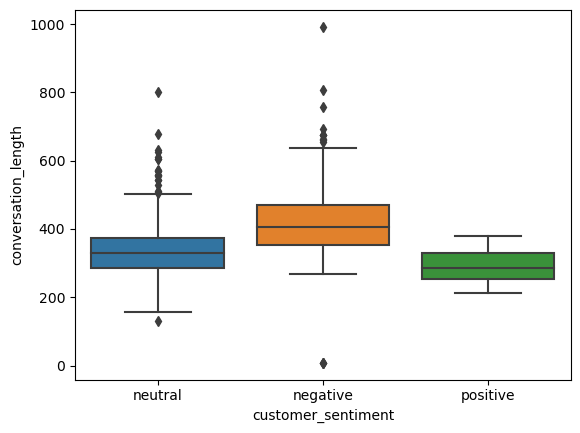

In [7]:
df['conversation_length'] = df['conversation'].apply(lambda x: len(x.split()))

sns.boxplot(data=df, x='customer_sentiment', y='conversation_length')

Negative emotions generally lead to longer (and more variable) conversations. This may indicate that customer dissatisfaction requires more explanation. Positive emotions are associated with shorter and more consistent conversations. In other words, satisfied users may have reached a solution more quickly.
Neutral conversations tend to be of moderate length.

## Correlation Analysis

In [8]:
from sklearn.preprocessing import LabelEncoder

df_encoded = df.copy()
for col in df_encoded.select_dtypes(include='object').columns:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])

correlation_matrix = df_encoded.corr()

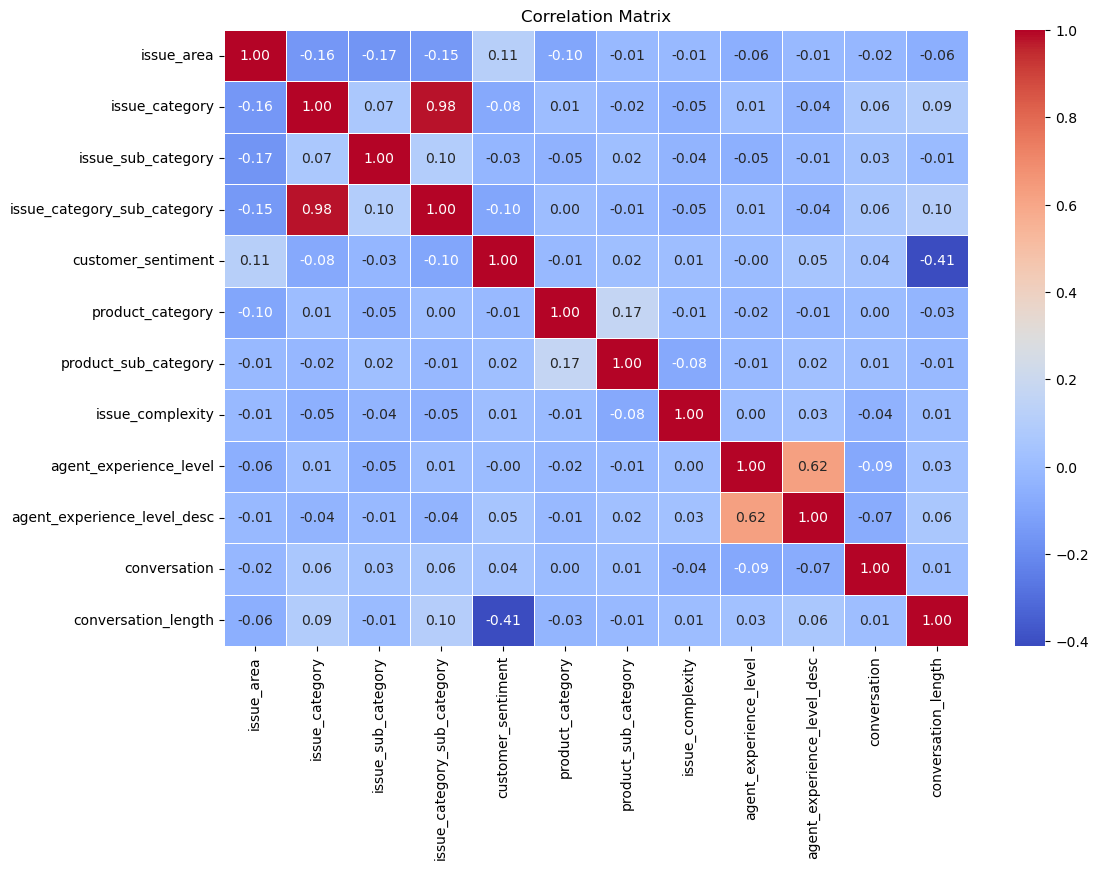

In [9]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

There is a strong negative correlation (-0.41) between customer sentiment and conversation length. This suggests that as customer sentiment becomes more negative, conversation length tends to increase.

## Preparing the dataset

In [10]:
df = df[['conversation', 'customer_sentiment']]

In [11]:
import re

# Make it lowercase
df['conversation'] = df['conversation'].str.lower()

#  Remove non-text elements
def clean_text(text):
    text = re.sub(r'\S+@\S+', '', text)  # remove emails
    text = re.sub(r'\+?\d[\d\-\s]+\d', '', text)  # remove phone numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # remove punctuation and numbers
    text = re.sub(r'\s+', ' ', text).strip() # remove extra space
    
    text = re.sub(r"my name is \w+", '', text)
    
    return text


df['conversation'] = df['conversation'].apply(clean_text)


In [12]:
def remove_agent_phrases(text):
    phrases = [
        "how may i assist you", 
        "thank you for calling", 
        "you're welcome", 
        "is there anything else i can assist you with",
        "thank you for waiting",
        "hi", 
        "goodbye"
    ]
    for phrase in phrases:
        text = text.replace(phrase, '')
    return text.strip()

df['conversation'] = df['conversation'].apply(lambda x: remove_agent_phrases(x.lower()))

In [13]:
df.loc[0]["conversation"]

'agent  brownbox customer support   today customer  tom im trying to log in to my account to purchase an oven toaster grill otg but im unable to proceed as its asking for mobile number or email verification can you help me with that agent sure i can assist you with that may i know your registered mobile number or email address please customer my registered mobile number is agent thank you let me check that for you im sorry to inform you that we dont have ts number on our records can you please confirm if ts is the correct number customer oh im sorry i might have registered with a different number can you please check with my email address instead its agent sure let me check that for you after a few moments i see that we have your email address on our records well be sending you a verification code shortly please check your email and let me know once you receive it customer okay i received the code what do i do with it agent please enter the verification code in the field provided and c

In [14]:
train_df = df

# Encode labels
label_encoder = LabelEncoder()
train_df['label'] = label_encoder.fit_transform(train_df['customer_sentiment'])

In [15]:
train_df["label"].unique()

array([1, 0, 2])

In [16]:
import os
import pickle
import numpy as np
import tiktoken  # make sure it's installed: pip install tiktoken

# Initialize GPT-2 tokenizer
enc = tiktoken.get_encoding("gpt2")  # You can also try "p50k_base" or "r50k_base"

# Encode/decode functions
def encode(s):
    return enc.encode(s)

def decode(toks):
    return enc.decode(toks)

# Split the data
n = len(train_df)
train_data = train_df[:int(n * 0.9)]
val_data = train_df[int(n * 0.9):]

# Encode texts
train_data = [(encode(text), label) for text, label in zip(train_data['conversation'], train_data['label'])]
val_data = [(encode(text), label) for text, label in zip(val_data['conversation'], val_data['label'])]

# Save binary
out_dir = 'data/sentiment'
os.makedirs(out_dir, exist_ok=True)


# Save tokenizer meta info (only vocab size here, no stoi/itos needed)
meta = {
    'vocab_size': enc.n_vocab,
    'tokenizer': 'gpt2'
}
with open(os.path.join(out_dir, 'meta.pkl'), 'wb') as f:
    pickle.dump(meta, f)
    
with open("data/sentiment/train_data.pkl", "wb") as f:
    pickle.dump(train_data, f)

with open("data/sentiment/val_data.pkl", "wb") as f:
    pickle.dump(val_data, f)

In [17]:
!wandb login

wandb: Currently logged in as: ovguyo to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [18]:
os.chdir('assignment_1')

In [19]:
!pwd

/home/proven/PycharmProjects/sentiment/assignment_1


In [20]:
!export CUDA_LAUNCH_BLOCKING=1

## Training from scratch

In [ ]:
!python train.py config/train_customer_sentiment.py --compile=False --wandb_log=True

Overriding config with config/train_customer_sentiment.py:
# train a miniature character-level shakespeare model
# good for debugging and playing on macbooks and such

out_dir = 'out'
eval_interval = 250  # keep frequent because we'll overfit
eval_iters = 200
log_interval = 50  # don't print too often

# we expect to overfit on this small dataset, so only save when val improves
always_save_checkpoint = False

wandb_log = False  # override via command line if you like
wandb_project = 'customer-sentiment'
wandb_run_name = 'nano-gpt'

dataset = 'sentiment'
gradient_accumulation_steps = 1
batch_size = 64
block_size = 1024  # context of up to 256 previous characters

# baby GPT model :)
n_layer = 6
n_head = 6
n_embd = 384
dropout = 0.1

learning_rate = 2e-3  # with baby networks can afford to go a bit higher
max_iters = 2000
lr_decay_iters = 2000  # make equal to max_iters usually
min_lr = 1e-4  # learning_rate / 10 usually
beta2 = 0.99  # make a bit bigger because number of tokens per iter

## Finetuning

In [22]:
!python train.py config/finetune_customer_sentiment.py --compile=False --wandb_log=True

Overriding config with config/finetune_customer_sentiment.py:
import time

out_dir = 'out'
eval_interval = 5
eval_iters = 40
wandb_log = False # feel free to turn on
wandb_project = 'customer-sentiment'
wandb_run_name = 'ft-' + str(time.time())

dataset = 'sentiment'
init_from = 'gpt2' # this is the GPT-2 model

# only save checkpoints if the validation loss improves
always_save_checkpoint = False

# the number of examples per iter:
batch_size = 1
gradient_accumulation_steps = 32
max_iters = 20

# finetune at constant LR
learning_rate = 3e-5
decay_lr = False

Overriding: compile = False
Overriding: wandb_log = True
tokens per iteration will be: 32,768
found vocab_size = 50257 (inside data/sentiment/meta.pkl)
Initializing from OpenAI GPT-2 weights: gpt2
loading weights from pretrained gpt: gpt2
forcing vocab_size=50257, block_size=1024, bias=True
overriding dropout rate to 0.0
number of parameters: 123.65M
num decayed parameter tensors: 50, with 124,318,464 parameters
num non-decayed pa

In [24]:
test_df = pd.read_csv("data/customer_service/test.csv")
test_df = test_df[['conversation', 'customer_sentiment']]

In [25]:
test_df['conversation'] = test_df['conversation'].apply(clean_text)
test_df['conversation'] = test_df['conversation'].apply(lambda x: remove_agent_phrases(x.lower()))

In [26]:
test_df['label'] = label_encoder.fit_transform(test_df['customer_sentiment'])
test_texts = test_df['conversation'].astype(str).tolist()
test_labels = test_df['label'].tolist()

In [27]:
test_df["label"].unique()

array([0, 1, 2])

In [28]:
# Load model
from model import GPTConfig, GPT
import torch

out_dir = 'out'
ckpt_path = os.path.join(out_dir, 'ckpt.pt')
checkpoint = torch.load(ckpt_path, map_location="cuda")
gptconf = GPTConfig(**checkpoint['model_args'])
model = GPT(gptconf, num_classes=3)

number of parameters: 29.92M


In [29]:
model

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(50257, 384)
    (wpe): Embedding(256, 384)
    (drop): Dropout(p=0.2, inplace=False)
    (h): ModuleList(
      (0-5): 6 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=384, out_features=1152, bias=False)
          (c_proj): Linear(in_features=384, out_features=384, bias=False)
          (attn_dropout): Dropout(p=0.2, inplace=False)
          (resid_dropout): Dropout(p=0.2, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=384, out_features=1536, bias=False)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=1536, out_features=384, bias=False)
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (classifier): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=384, out_features=3, bias=True)
  )
)

In [30]:
batch_size = 8
preds = []
targets = []
device = "cuda"

model = model.to(device)

model.eval()

with torch.no_grad():
    for i in range(0, len(test_texts), batch_size):
        batch_texts = test_texts[i:i+batch_size]
        batch_labels = test_labels[i:i+batch_size]

        # Encode and pad
        encoded = [encode(text.lower())[:256] for text in batch_texts]
        max_len = max(len(seq) for seq in encoded)
        padded = [seq + [0] * (max_len - len(seq)) for seq in encoded]

        input_tensor = torch.tensor(padded, dtype=torch.long).to(device)
        label_tensor = torch.tensor(batch_labels, dtype=torch.long).to(device)

        # Forward pass (logits = [batch_size, num_classes])
        logits, _ = model(input_tensor)
        pred = torch.argmax(logits, dim=-1)
        
        preds.extend(pred.cpu().tolist())
        targets.extend(label_tensor.cpu().tolist())

In [31]:
# Evaluation
from sklearn.metrics import accuracy_score, classification_report

print("Accuracy:", accuracy_score(targets, preds))
print(classification_report(targets, preds))  # if using LabelEncoder

Accuracy: 0.3333333333333333
              precision    recall  f1-score   support

           0       0.34      1.00      0.51        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30



/home/proven/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/proven/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/proven/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
